In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.externals.six import StringIO  
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

pd.options.display.max_rows = 4000
plt.style.use('ggplot')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


<b>Read Data</b>

In [2]:
train_data_path='C:/Users/karim.afifi/Desktop/ASU/Data Visualization (CSE578)/Projects/adult.csv'
test_data_path='C:/Users/karim.afifi/Desktop/ASU/Data Visualization (CSE578)/Projects/adult_test.csv'

In [3]:
train_data=pd.read_csv(train_data_path, na_values='?')
test_data=pd.read_csv(test_data_path, na_values='?')

In [4]:
train_data.shape

(32561, 15)

In [5]:
train_data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
Income            object
dtype: object

In [6]:
train_data['education-num']=train_data['education-num'].astype('str')
test_data['education-num']=test_data['education-num'].astype('str')

In [7]:
train_data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
Income               0
dtype: int64

In [8]:
(train_data['Income'].value_counts()/train_data['Income'].value_counts().sum())*100

<=50K    75.919044
>50K     24.080956
Name: Income, dtype: float64

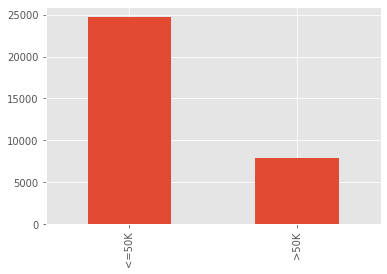

In [9]:
train_data['Income'].value_counts().plot.bar()

<b>We have a class imbalance. We need to use a balanced accuracy criterion</b>

<hr>

<b>Predicting using Decision Tree Classifier</b>

In [10]:
train_data.dropna(axis=0, inplace=True)
test_data.dropna(axis=0, inplace=True)

In [11]:
X_train=train_data.iloc[:,:-1]
y_train=train_data.iloc[:,-1]

In [12]:
X_test=test_data.iloc[:,:-1]
y_test=test_data.iloc[:,-1]

<b>Remove education since it is redundant to education-num</b>

In [13]:
X_train.drop(['education-num'], axis=1, inplace=True)

In [14]:
X_test.drop(['education-num'], axis=1, inplace=True)

In [15]:
X_train_hot_enc=X_train.copy(deep=True)
X_test_hot_enc=X_test.copy(deep=True)
X_all_hot_enc=X_train_hot_enc.append(X_test_hot_enc)

In [16]:
X_train_hot_enc.shape

(30162, 13)

In [17]:
X_test_hot_enc.shape

(15060, 13)

In [18]:
X_all_hot_enc=pd.get_dummies(X_all_hot_enc)

In [19]:
X_train_hot_enc=X_all_hot_enc.iloc[:30162, :]
X_test_hot_enc=X_all_hot_enc.iloc[30162:, :]

In [20]:
X_train_hot_enc.shape

(30162, 103)

In [21]:
X_test_hot_enc.shape

(15060, 103)

<b>Encode categorical variables' values to numerical ones since the model only accepts numerical variables</b>

In [22]:
X_train_temp=pd.DataFrame()
for (columnName, columnData) in X_train.iteritems():
    le = preprocessing.LabelEncoder()
    X_train_temp[columnName]=le.fit_transform(columnData)
X_train=X_train_temp
del X_train_temp

In [23]:
X_test_temp=pd.DataFrame()
for (columnName, columnData) in X_test.iteritems():
    le = preprocessing.LabelEncoder()
    X_test_temp[columnName]=le.fit_transform(columnData)
X_test=X_test_temp
del X_test_temp

In [24]:
le = preprocessing.LabelEncoder()
y_train=le.fit_transform(y_train)

In [25]:
le = preprocessing.LabelEncoder()
y_test=le.fit_transform(y_test)

<b>Perform gradient search to find best model parameters. We used scoring='balanced-accuracy' instead of accuracy since the classes are imbalanced. If we used accuracy as a metric, the model might seem to perform better but in reality, it might be doing better predicting one class than the other. What we want is optimize for predicting the two classes. Balanced accuracy calculates the average accuracy for predicting the two classes: (class 1 pred. acc. + class 2 pred. acc.)/2<br>Different scoring metrics: https://scikit-learn.org/stable/modules/model_evaluation.html</b>

<b>we will limit the max_depth and max_leaf_nodes of the tree to be able to visualize it. This might reduce the prediction accuracy but we won't be capable of visualizing it without limiting its growth</b>

In [26]:
est = DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_leaf_nodes': [2, 4, 5, 8, 10, 12, 14], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 10, 15, 20]}
gs_class = GridSearchCV(est, param_grid, n_jobs=-1, verbose=0, cv=5, scoring='balanced_accuracy')
res_cv=gs_class.fit(X_train_hot_enc, y_train)

In [27]:
res_cv.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': 14,
 'splitter': 'best'}

<b>Find feature importances in order to reduce the number of features for better visualization. Since the model might output different feature importances on different runs, we need to run the model 100 times and take the feature importances average for each variable. The reason behind that the feature importances might differ is that if 2 variables are highly correlated with each other and they can both influence the target variable the same, the model picks one of them randomly. This might decrease the feature importance of some variables while they are beneficial in prediciting the target</b>

In [28]:
feature_importances=[]

for i in range(100):
    est = DecisionTreeClassifier(**res_cv.best_params_)
    est.fit(X_train, y_train)
    feature_importances.append(est.feature_importances_*100)

In [29]:
feature_imp_final=[[], [], [], [], [], [], [], [], [], [], [], [], []]

In [30]:
for fi in feature_importances:
    for i in range(len(fi)):
        feature_imp_final[i].append(fi[i])

In [31]:
feature_imp_final_temp=[]

for fi in feature_imp_final:
    feature_imp_final_temp.append(np.mean(fi))

feature_imp_final=feature_imp_final_temp
del feature_imp_final_temp

<b>Lets now plot the relative average feature importance for each variable</b>

In [32]:
fi_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': feature_imp_final})
fi_df.sort_values('Importance', axis=0, ascending=False, inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

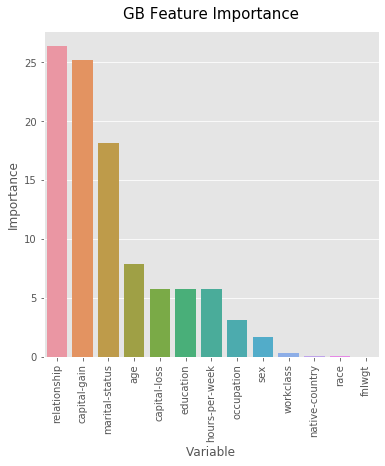

In [33]:
plt.figure(figsize=(6,6))
plt.title('GB Feature Importance', fontsize=15, pad=12)
sns.barplot(fi_df['Variable'], fi_df['Importance'])
plt.xticks(rotation=90)

<b>Select only the top 5 important features to be able to visualize the final tree. This can reduce the performance a little bit but extracting insights from the model is more important for this project than having higher accuracy</b>

In [34]:
X_train=X_train[list(fi_df[:5]['Variable'].values)]
X_test=X_test[list(fi_df[:5]['Variable'].values)]

<b>Using the filtered dataset and the best parameters determined by gradient search, lets build the final model that we will use to assess the accuracy and for visualization. 

In [35]:
est = DecisionTreeClassifier(**res_cv.best_params_)
est.fit(X_train_hot_enc, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
                       max_features='auto', max_leaf_nodes=14,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

<b>The predicting accuracy. This is the same metric reported in the adult.names file. Anything above 80 would be great!</b>

In [36]:
y_train_predict=est.predict(X_train_hot_enc)
accuracy_score(y_train, y_train_predict)

0.8329023274318679

In [37]:
bacc_cv=cross_val_score(est, X_train_hot_enc, y_train, cv=5, scoring='accuracy')
print(bacc_cv)
print(np.average(bacc_cv))

[0.78932538 0.80341455 0.8083872  0.81117374 0.82490466]
0.8074411066818689


In [38]:
y_test_predict=est.predict(X_test_hot_enc)
accuracy_score(y_test, y_test_predict)

0.8364541832669322

<b>The balanced accuracy. This should be lower and if they have reported the balanced accuracy in the adult.names file, it would be also lower. If it is above 70%, it would be fine.</b>

In [39]:
y_train_predict=est.predict(X_train_hot_enc)
balanced_accuracy_score(y_train, y_train_predict)

0.7318571205692886

In [40]:
bacc_cv=cross_val_score(est, X_train_hot_enc, y_train, cv=5, scoring='balanced_accuracy')
print(bacc_cv)
print(np.average(bacc_cv))

[0.70097863 0.6842789  0.61700415 0.65712103 0.53544995]
0.6389665320656678


In [41]:
y_test_predict=est.predict(X_test_hot_enc)
balanced_accuracy_score(y_test, y_test_predict)

0.7339538922725543

<b>Visualizing the decision tree</b>

In [42]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(est, out_file=dot_data,  
                filled=True, rounded=True,
                class_names=True, feature_names=list(X_train_hot_enc.columns.values),
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found